In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random

In [2]:
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


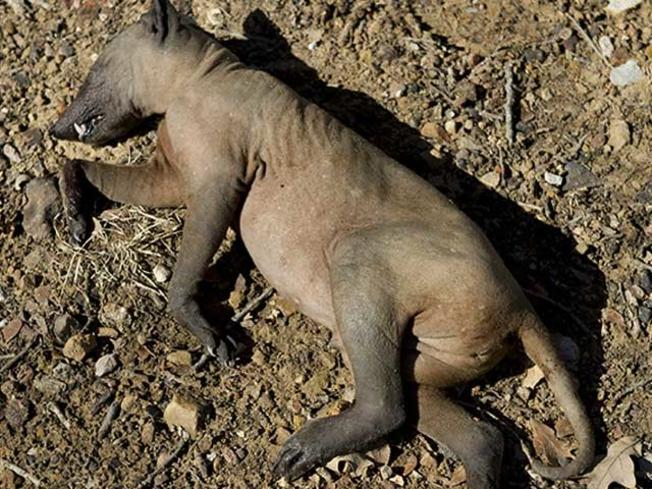

raccoon


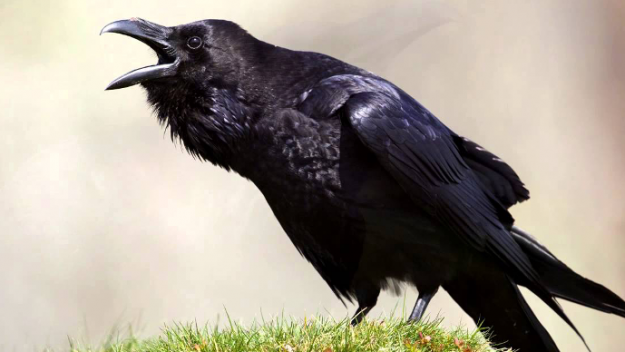

raven


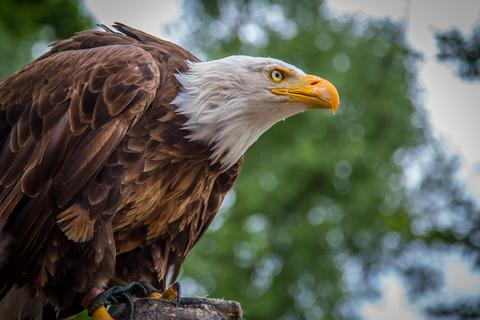

bald_eagle


In [3]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])

In [4]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [5]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [6]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [7]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [8]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

# feel free to modify these Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [9]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [10]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

In [11]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    value = tf.reshape(value, [-1])
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.numpy()))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature0, feature1):
    """ Creates a tf.Example message ready to be written to a file. """
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {'feature0': _float_feature(feature0),
               'feature1': _int64_feature(feature1),}
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(serialize_example, (f0,f1), tf.string)
    return tf.reshape(tf_string, ()) # The result is a scalar

In [16]:
# apply the function to each element in the dataset
serialized_features_dataset_train = dataset_train.map(tf_serialize_example)
serialized_features_dataset_val = dataset_val.map(tf_serialize_example)

# write them to a TFRecord file
filename = 'train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset_train)

filename = 'val.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset_val)

In [12]:
# reading a TFRecord file
dataset_train = tf.data.TFRecordDataset('train.tfrecord')
dataset_val = tf.data.TFRecordDataset('val.tfrecord')
   
# Create a description of the features.
feature_description = {
    'feature0': tf.io.VarLenFeature(tf.float32),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset_train = dataset_train.map(_parse_function)
parsed_dataset_val = dataset_val.map(_parse_function)

In [13]:
def reshape_function(features):
    img = tf.sparse.to_dense(features['feature0'])
    img = tf.reshape(img, [300,300,3])
    label = features['feature1']
    return img, label

dataset_train = parsed_dataset_train.map(reshape_function)
dataset_val = parsed_dataset_val.map(reshape_function)

(300, 300, 3)


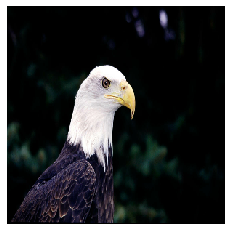

bald_eagle
(300, 300, 3)


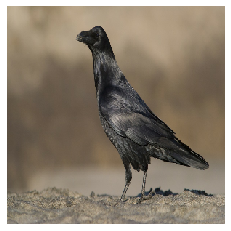

raven
(300, 300, 3)


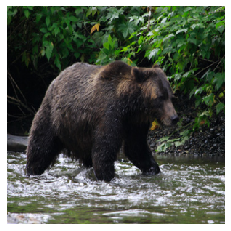

black_bear


In [14]:
# show one image here.
for data in dataset_train.take(3):
    img = data[0]
    label = data[1]
    print(img.shape)
    plt.imshow(img) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label.numpy()])

In [15]:
# parse training data
def map_fun(image,label):
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(image,label):
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [16]:
dataset_train = dataset_train.map(map_fun)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE)

dataset_val = dataset_val.map(map_fun_test)
dataset_val = dataset_val.batch(BATCH_SIZE)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [17]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [18]:
wild_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
wild_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
wild_model.fit(dataset_train, validation_data=dataset_val, epochs=5)

Epoch 1/5
180/180 [==============================] - 188s 1s/step - loss: 2.7025 - accuracy: 0.5657 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
180/180 [==============================] - 185s 1s/step - loss: 0.7018 - accuracy: 0.7801 - val_loss: 0.2955 - val_accuracy: 0.9093
Epoch 3/5
180/180 [==============================] - 185s 1s/step - loss: 0.6001 - accuracy: 0.8205 - val_loss: 0.2912 - val_accuracy: 0.9059
Epoch 4/5
180/180 [==============================] - 187s 1s/step - loss: 0.5307 - accuracy: 0.8376 - val_loss: 0.2849 - val_accuracy: 0.9052
Epoch 5/5
180/180 [==============================] - 189s 1s/step - loss: 0.4836 - accuracy: 0.8514 - val_loss: 0.2091 - val_accuracy: 0.9351
